In [1]:
from src.tuning.load_estimators import load_all_forecasters, get_estimator

# This loads all sktime forecasters to be accessible by their class name -> don't need to run again
forecasters = load_all_forecasters()

### Set patient, model, and best params config

In [2]:
patient = "p04"

# Set model as sktime forecaster class name
# model = "TinyTimeMixerForecaster"
# model = "ARCH"
model = "AutoARIMA"
# model = "ARIMA"
forecaster_class = get_estimator(forecasters, model)

# Set relative path to config yaml file with params for model
# config_path = "../../models/configs/TinyTimeMixerForecaster.yaml"
# config_path = "../../models/configs/ARCH.yaml"
config_path = "../../models/configs/AutoARIMA.yaml"
# config_path = "../../models/configs/ARIMA.yaml"

### Load data for one patient

In [3]:
from src.data.data_loader import BrisT1DDataLoader

# Split up data into day and night
loader = BrisT1DDataLoader(use_cached=True)

train_df = loader.train_data[loader.train_data["p_num"] == patient]
test_df = loader.validation_data[loader.validation_data["p_num"] == patient]

TIME_STEP_SIZE = (
    train_df["datetime"].iloc[1] - train_df["datetime"].iloc[0]
).components.minutes

if TIME_STEP_SIZE != 5 and TIME_STEP_SIZE != 15:
    error = """
    First time step is not 5 or 15 minutes. Look at the most common time step size.
    """

### Reduce columns and impute missing values on training set

In [4]:
# import pandas as pd
from src.tuning.benchmark import impute_missing_values


def reduce_features(df):
    # Make sure index is set to datetime
    p_df = df.iloc[:]
    # p_df.set_index("datetime", inplace=True)
    # p_df = p_df.asfreq('5T', method='pad')

    # Reduce features
    y_feature = ["bg-0:00"]
    x_features = [
        # "hr-0:00", # -> has NaNs
        "steps-0:00",
        "cals-0:00",
        "cob",
        "carb_availability",
        "insulin_availability",
        "iob",
    ]
    p_df = p_df[x_features + y_feature]

    # Impute with default methods
    p_df = impute_missing_values(p_df, columns=x_features)
    p_df = impute_missing_values(p_df, columns=y_feature)

    y, X = p_df[y_feature], p_df[x_features]
    return y, X

In [5]:
y_train, X_train = reduce_features(train_df)

y_train.describe()

,bg-0:00
count,19018.000000
mean,7.756691
std,2.238321
min,2.200000
25%,6.200000
50%,7.400000
75%,9.000000
max,18.400000


In [6]:
X_train.describe()

,steps-0:00,cals-0:00,cob,carb_availability,insulin_availability,iob
count,19018.000000,19018.000000,19018.000000,19018.000000,19018.000000,19018.000000
mean,17.251604,5.598861,54.417761,25.460518,1.343283,24.501235
std,62.918089,4.465585,60.011676,26.637432,0.674803,12.439293
min,0.000000,0.910000,0.000000,0.000000,0.000000,0.402800
25%,0.000000,4.550000,3.785777,2.218599,0.798462,14.590276
50%,0.000000,4.550000,39.017456,19.394003,1.201751,21.851112
75%,0.000000,5.360000,85.876988,40.244838,1.749417,31.727010
max,673.000000,42.510000,784.625677,289.665750,4.754801,96.746960


### Load model with best params

In [7]:
from src.utils.config_loader import load_yaml_config

params = load_yaml_config(config_path)

forecaster = forecaster_class(**params)

### Fit model on training set

In [8]:
import numpy as np

HOURS_TO_PREDICT = 6
NUM_STEPS = HOURS_TO_PREDICT * 60 // TIME_STEP_SIZE

fh = np.arange(1, NUM_STEPS + 1)

forecaster.fit(y=y_train, X=X_train, fh=fh)

/home/cjrisi/Projects/diabetes/nocturnal-hypo-gly-prob-forecast/.noctprob-venv/lib/python3.12/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


AutoARIMA(max_p=16, max_q=16, n_jobs=-1, seasonal=False, start_p=4, start_q=4,
          suppress_warnings=True)

### Plot predicted glucose levels

/home/cjrisi/Projects/diabetes/nocturnal-hypo-gly-prob-forecast/.noctprob-venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/cjrisi/Projects/diabetes/nocturnal-hypo-gly-prob-forecast/.noctprob-venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/cjrisi/Projects/diabetes/nocturnal-hypo-gly-prob-forecast/.noctprob-venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/cjrisi/Projects/diabetes/nocturnal-hypo-gly-prob-forecast

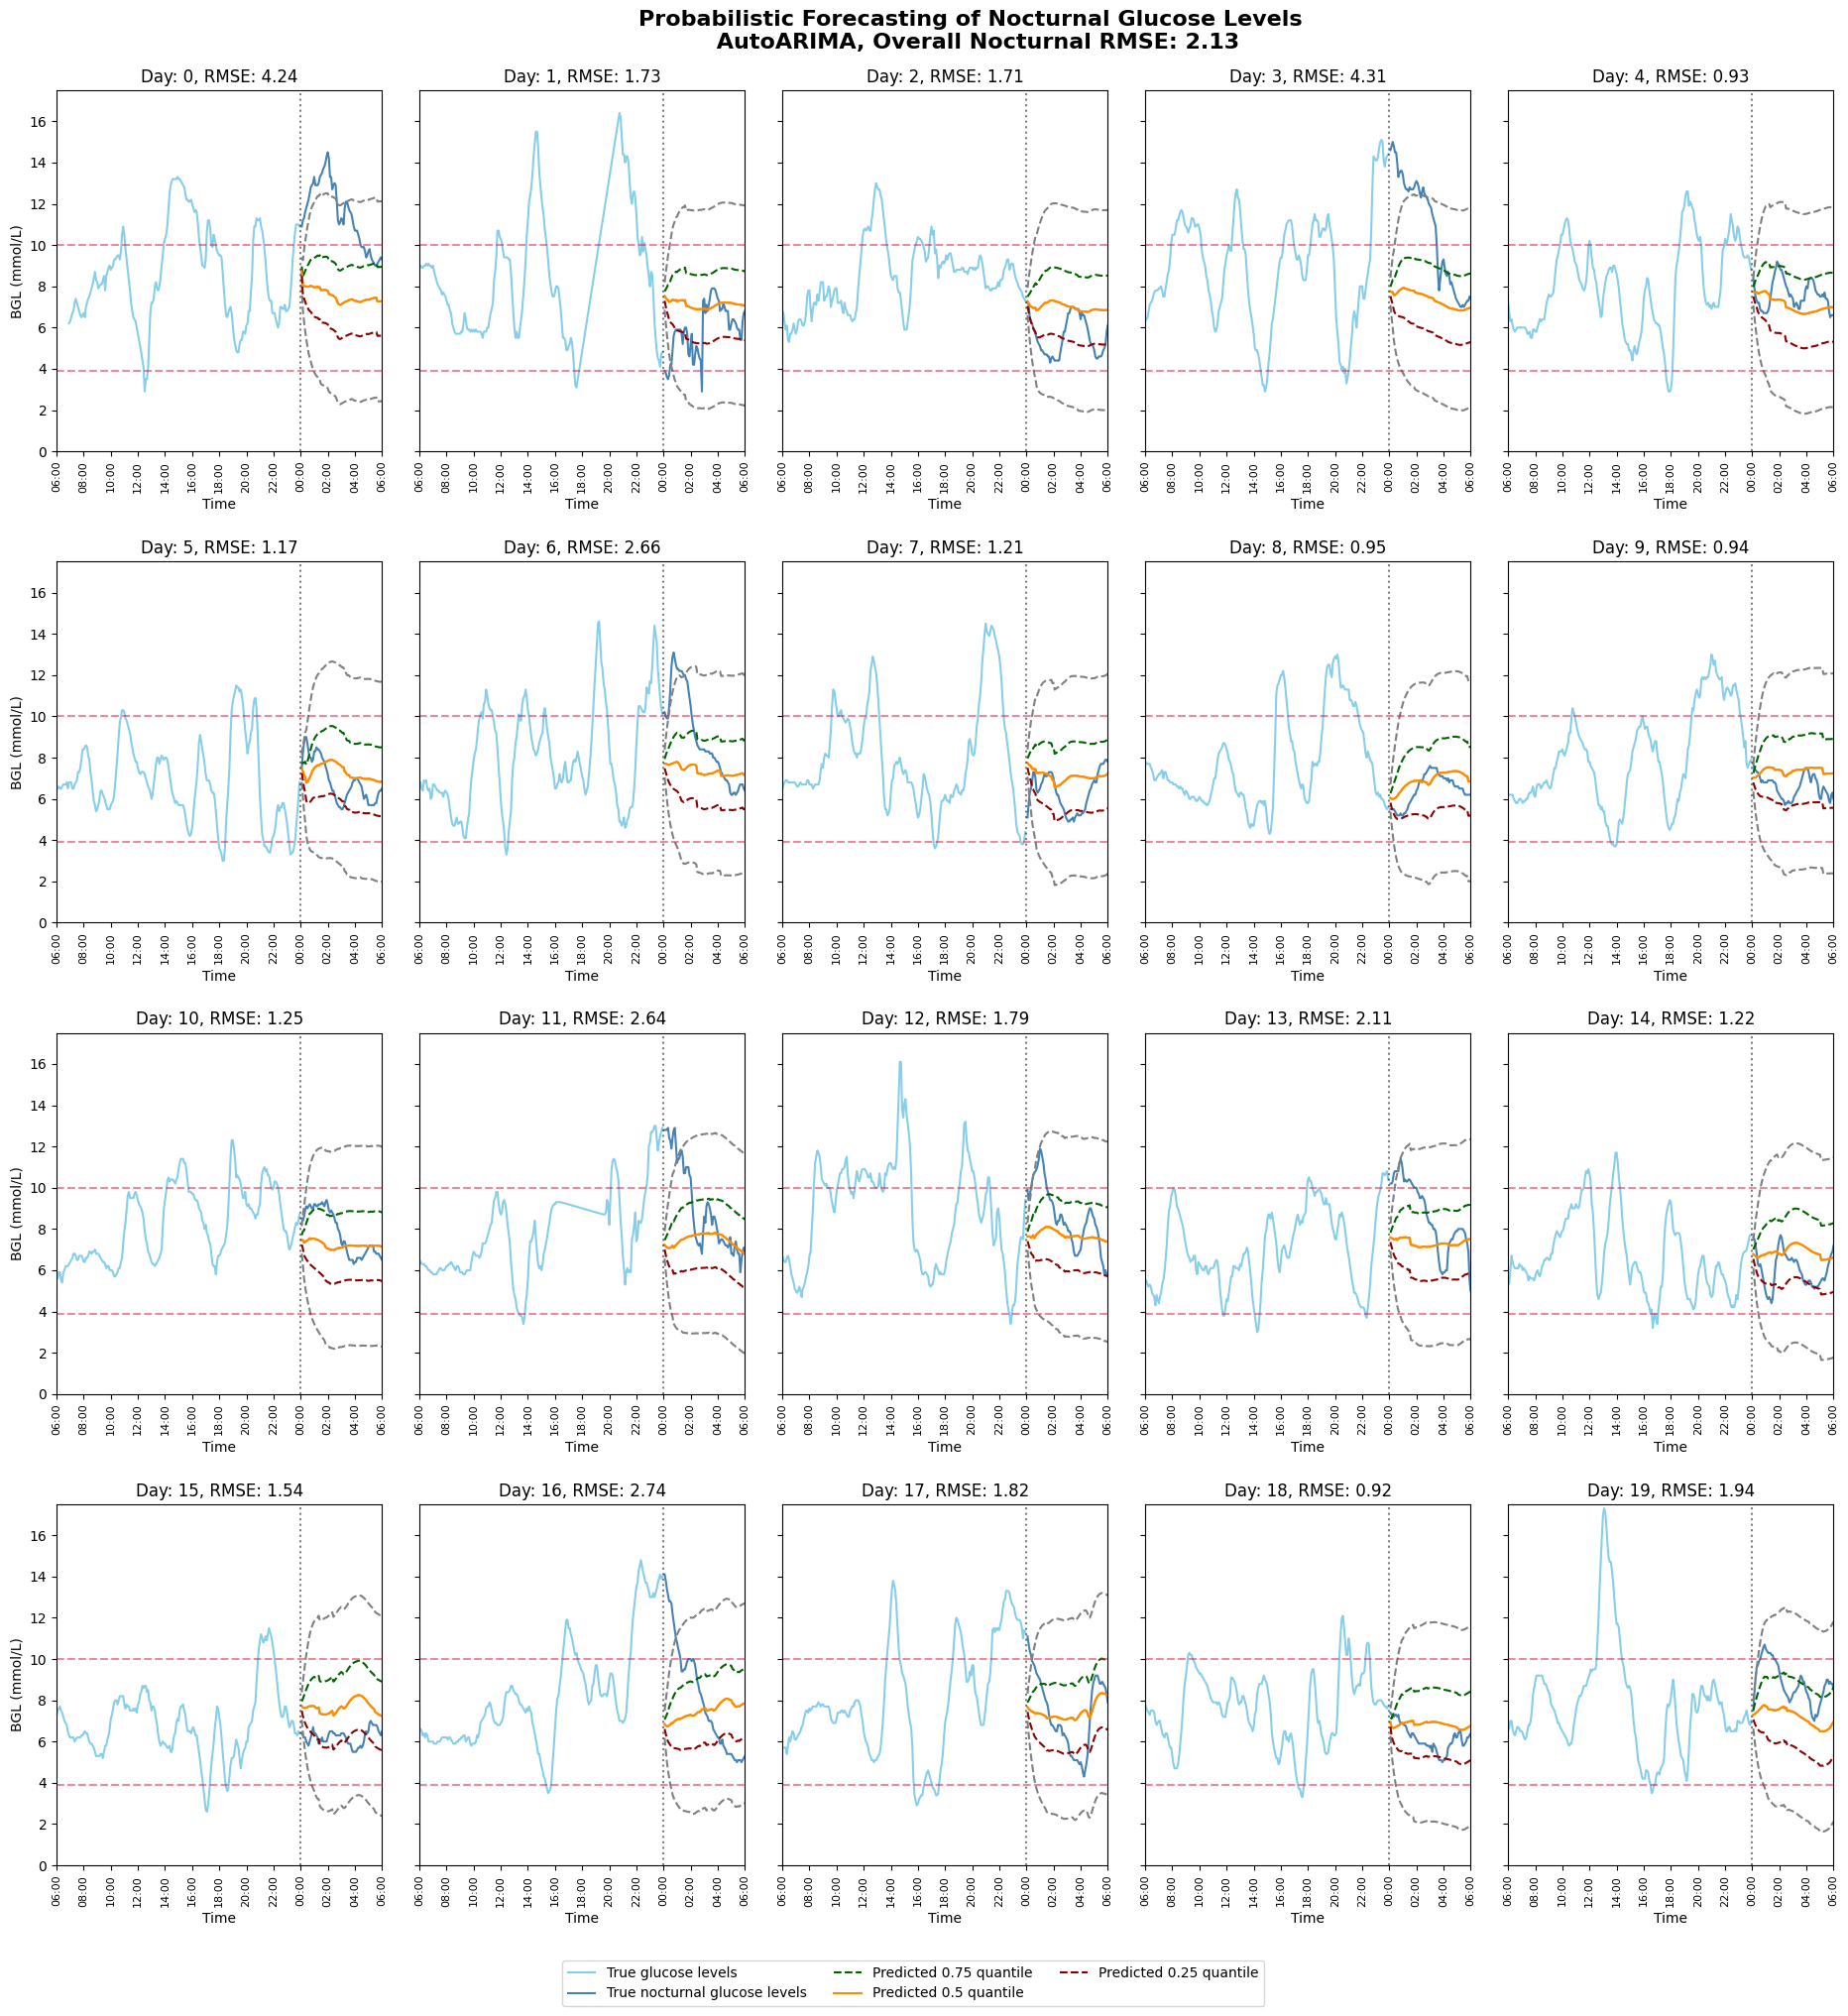

1.8904714292905673


In [11]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

# Create time index once (288 steps of 5 minutes from 6AM to 6AM next day)
time_index = pd.date_range(
    start="2024-01-01 06:00:00", end="2024-01-02 06:00:00", periods=289
)

# Create a figure with multiple subplots
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(20, 20))
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

# Initialize the subplot counter
subplot_idx = 0
RMS_ERRORS = np.array([])
ERRORS_NIGHT = np.array([])

# Store lines for legend
legend_lines = []
legend_labels = []

# Loop over each day split and create one plot per day
for _, train_period, test_period in loader.get_validation_day_splits(patient):
    y_day, X_day = reduce_features(train_period)
    y_night, X_night = reduce_features(test_period)

    if X_day.isna().sum().any() > 0:
        print(X_day)
    if X_night.isna().sum().any() > 0:
        print(X_night)

    # Update the model with the true glucose levels for the day
    forecaster.update(y=y_day, X=X_day, update_params=False)

    ######## Determine MSE between predicted and true glucose levels ########
    predicted_bg = forecaster.predict(fh=fh, X=X_night)

    ######## Plot true glucose levels ########
    ax = axes[subplot_idx]
    daystart = 216 - len(y_day)
    day_line = ax.plot(
        time_index[daystart : len(y_day) + daystart],
        y_day["bg-0:00"],
        color="skyblue",
        label="True glucose levels",
    )[0]
    night_line = ax.plot(
        time_index[-72:],
        y_night["bg-0:00"],
        color="steelblue",
        linestyle="-",
        label="True nocturnal glucose levels",
    )[0]

    ######## Plot predicted glucose levels ########
    predicted_bg_ax = ax.plot(
        time_index[-72:],
        predicted_bg,
        color="darkorange",
        linestyle="-",
        label="Predicted glucose levels",
    )[0]

    ######## Plot predicted glucose intervals ########
    coverage = 0.95
    pred_int = forecaster.predict_interval(fh=fh, X=X_night, coverage=coverage)[
        "bg-0:00"
    ][coverage]
    upper_interval = ax.plot(
        time_index[-72:],
        pred_int["upper"],
        label="Predicted upper interval",
        linestyle="--",
        color="grey",
    )[0]
    lower_interval = ax.plot(
        time_index[-72:],
        pred_int["lower"],
        label="Predicted lower interval",
        linestyle="--",
        color="grey",
    )[0]

    # ######## Plot predicted glucose quantiles ########
    quantiles = [0.75, 0.5, 0.25]
    pred_int = forecaster.predict_quantiles(fh=fh, X=X_night, alpha=quantiles)[
        "bg-0:00"
    ]
    upper_quantile = ax.plot(
        time_index[-72:],
        pred_int[quantiles[0]],
        linestyle="--",
        label="0.95 quantile",
        color="darkgreen",
    )[0]
    mid_quantile = ax.plot(
        time_index[-72:],
        pred_int[quantiles[1]],
        label="0.5 quantile",
        color="darkorange",
    )[0]
    lower_quantile = ax.plot(
        time_index[-72:],
        pred_int[quantiles[2]],
        linestyle="--",
        label="0.05 quantile",
        color="darkred",
    )[0]

    # Format x-axis
    ax.xaxis.set_major_locator(
        mdates.HourLocator(interval=2)
    )  # Show ticks every 2 hours
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))  # Format as HH:MM

    mse = np.sqrt(np.mean((predicted_bg.values - y_night["bg-0:00"].values) ** 2))
    SE_NIGHT = (predicted_bg.values - y_night["bg-0:00"].values) ** 2
    ERRORS_NIGHT = np.append(ERRORS_NIGHT, SE_NIGHT)
    RMS_ERRORS = np.append(RMS_ERRORS, mse)
    ax.set_title(f"Day: {subplot_idx}, RMSE: {mse:.2f}")

    ######## Plot predicted glucose levels ########
    # Only store legend items from first subplot
    if subplot_idx == 0:
        legend_lines.extend(
            [day_line, night_line, upper_quantile, mid_quantile, lower_quantile]
        )
        legend_labels.extend(
            [
                "True glucose levels",
                "True nocturnal glucose levels",
                # "Predicted blood glucose level",
                # f"Predicted {coverage} coverage interval",
                f"Predicted {quantiles[0]} quantile",
                f"Predicted {quantiles[1]} quantile",
                f"Predicted {quantiles[2]} quantile",
            ]
        )

    # Set limits to show full 24-hour period
    ax.set_xlim(time_index[0], time_index[-1])

    # Add labels and formatting for each subplot (remove legend)
    ax.set_xlabel("Time", fontsize=10)
    # Hide y-axis labels for all plots except first in each row
    if subplot_idx % 5 != 0:  # If not first plot in row
        ax.yaxis.set_ticklabels([])
    else:
        ax.set_ylabel("BGL (mmol/L)", fontsize=10)
    ax.set_ylim(0, 17.5)

    ax.tick_params(axis="x", rotation=90, labelsize=8)
    # Add horizontal reference lines
    ax.axhline(
        y=3.9, color="crimson", linestyle="--", alpha=0.5
    )  # Hypoglycemia threshold
    ax.axhline(
        y=10.0, color="crimson", linestyle="--", alpha=0.5
    )  # Hyperglycemia threshold
    ax.axvline(
        x=time_index[216], color="black", linestyle=":", alpha=0.5
    )  # Nocturnal start

    # Update the model with the true glucose levels for the night
    forecaster.update(y=y_night, X=X_night, update_params=False)

    # Increment the subplot index for the next day
    subplot_idx += 1

TOTAL_TEST_RMSE = np.sqrt(np.mean(ERRORS_NIGHT))

fig.suptitle(
    f"Probabilistic Forecasting of Nocturnal Glucose Levels \n {model}, Overall Nocturnal RMSE: {TOTAL_TEST_RMSE:.2f}",
    fontweight="bold",
    fontsize=16,
)

# Add a single legend outside the subplots
fig.legend(legend_lines, legend_labels, ncols=3, bbox_to_anchor=(0.65, 0.0))

# Adjust layout to avoid overlap with the legend
plt.tight_layout(rect=[0, 0, 0.95, 1], pad=2.0)

# Show the figure with multiple subplots
plt.show()


print(RMS_ERRORS.mean())

In [10]:
fig.suptitle(
    f"Point Forecasting of Nocturnal Glucose Levels over 20 days \n {model} (Zero-Shot), Overall Nocturnal RMSE: {TOTAL_TEST_RMSE:.2f}",
    fontweight="bold",
    fontsize=16,
)

# Add a single legend outside the subplots
fig.legend(legend_lines, legend_labels, ncols=3, bbox_to_anchor=(0.65, 0.0))

# Adjust layout to avoid overlap with the legend
plt.tight_layout(rect=[0, 0, 0.95, 1], pad=2.0)

# Show the figure with multiple subplots
plt.show()


print(RMS_ERRORS.mean())

<Figure size 640x480 with 0 Axes>

1.8904714292905673
